In [1]:
import pandas as pd
import transformers
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os
import glob
import shutil

directory = os.getenv('HOME') + '/aiffel/aiffelthon/added/'

In [11]:
# file 저장
data = pd.read_csv('metric_bencmark_file_0221.csv') # save file 

In [12]:
from transformers import AutoModel, AutoTokenizer

model_ckpt = 'Helsinki-NLP/opus-mt-ko-en'
model_ckpt2= 'circulus/kobart-trans-ko-en-v2' #bart`

# models
model = AutoModel.from_pretrained(model_ckpt)
model2 = AutoModel.from_pretrained(model_ckpt2)

# tokenizer

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
tokenizer2= AutoTokenizer.from_pretrained(model_ckpt2)

Some weights of the model checkpoint at Helsinki-NLP/opus-mt-ko-en were not used when initializing MarianModel: ['final_logits_bias']
- This IS expected if you are initializing MarianModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MarianModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at circulus/kobart-trans-ko-en-v2 were not used when initializing BartModel: ['lm_head.weight', 'final_logits_bias']
- This IS expected if you are initializing BartModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if y

In [16]:
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True, max_length=256)

def tokenize2(batch):
    return tokenizer2(batch['text'], padding=True, truncation=True, max_length=256)

In [17]:
import datasets

dataset = datasets.Dataset.from_pandas(data.reset_index())
datset = dataset.map(tokenize, batched=True, batch_size =None)
dataset2 = datasets.Dataset.from_pandas(data)
datset2 = dataset2.map(tokenize2, batched=True, batch_size =None)
ds = datasets.DatasetDict({'Marian' : dataset, 'KoBart' : dataset2})

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [18]:
ds

DatasetDict({
    Marian: Dataset({
        features: ['index', 'Unnamed: 0', 'text', 'dial', 'reg', 'eng', 'intent'],
        num_rows: 1000
    })
    KoBart: Dataset({
        features: ['Unnamed: 0', 'text', 'dial', 'reg', 'eng', 'intent'],
        num_rows: 1000
    })
})

---
# 밴치마크 클래스 만들기

In [19]:
# nlp_transformers chp 8 code 참고
from transformers import pipeline

class PerformanceBenchmark:
    def __init__(self, pipeline, dataset, optim_type="BERT baseline"):
        self.pipeline = pipeline
        self.dataset = dataset
        self.optim_type = optim_type
        
    def compute_bleu(self):
        # 나중에 정의합니다
        pass    

    def compute_size(self):
        # 나중에 정의합니다
        pass

    def time_pipeline(self):
        # 나중에 정의합니다
        pass
    
    def run_benchmark(self):
        metrics = {}
        metrics[self.optim_type] = self.compute_size()
        metrics[self.optim_type].update(self.time_pipeline())
        metrics[self.optim_type].update(self.compute_bleu())
        return metrics

In [70]:
from datasets import load_metric 
# !pip install sacrebleu
bleu_score = load_metric("sacrebleu")

def compute_bleu(self):
    """PerformanceBenchmark.compute_bleu() 메서드를 오버라이드합니다"""
    preds, labels = [], []
    for example in self.dataset:
        pred = self.pipeline(example["text"])[0]["translation_text"]
        label = [example["intent"]]
        labels.append(label)
        preds.append(pred)
    results = bleu_score.compute(predictions=preds, references=labels, smooth_method='floor',lowercase=True,use_effective_order=True)
    print(f"테스트 세트 블루 - {results['score']:.3f}")
    return results

PerformanceBenchmark.compute_bleu = compute_bleu

In [71]:
import torch
from pathlib import Path

def compute_size(self):
    """PerformanceBenchmark.compute_size() 메서드를 오버라이드합니다"""
    state_dict = self.pipeline.model.state_dict()
    tmp_path = Path("model.pt")
    torch.save(state_dict, tmp_path)
    # 메가바이트 단위로 크기를 계산합니다
    size_mb = Path(tmp_path).stat().st_size / (1024 * 1024)
    # 임시 파일을 삭제합니다
    tmp_path.unlink()
    print(f"모델 크기 (MB) - {size_mb:.2f}")
    return {"size_mb": size_mb}

PerformanceBenchmark.compute_size = compute_size

In [72]:
from time import perf_counter

def time_pipeline(self, query="What is the pin number for my account?"):
    """PerformanceBenchmark.time_pipeline() 메서드를 오버라이드합니다d"""
    latencies = []
    # 워밍업
    for _ in range(10):
        _ = self.pipeline(query)
    # 실행 측정
    for _ in range(100):
        start_time = perf_counter()
        _ = self.pipeline(query)
        latency = perf_counter() - start_time
        latencies.append(latency)
    # 통게 계산
    time_avg_ms = 1000 * np.mean(latencies)
    time_std_ms = 1000 * np.std(latencies)
    print(f"평균 레이턴시 (ms) - {time_avg_ms:.2f} +\- {time_std_ms:.2f}")
    return {"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms}

PerformanceBenchmark.time_pipeline = time_pipeline

In [73]:
import pandas as pd

def plot_metrics(perf_metrics, current_optim_type):
    df = pd.DataFrame.from_dict(perf_metrics, orient='index')

    for idx in df.index:
        df_opt = df.loc[idx]
        # 현재 최적화 방법을 점선으로 그립니다
        if idx == current_optim_type:
            plt.scatter(df_opt["time_avg_ms"], df_opt["score"], 
                        alpha=0.5, s=df_opt["size_mb"], label=idx, 
                        marker='$\u25CC$')
        else:
            plt.scatter(df_opt["time_avg_ms"], df_opt["score"], 
                        s=df_opt["size_mb"], label=idx, alpha=0.5)
            
    legend = plt.legend(bbox_to_anchor=(1,1))
    
    for handle in legend.legendHandles:
        handle.set_sizes([20])

    plt.ylim(5,50)
    # 가장 느린 모델을 사용해 x 축 범위를 정합니다
    plt.xlim(20, 200)
    plt.ylabel("Bleu-score")
    plt.xlabel("Average latency (ms)")
    plt.show()

In [113]:
# Marian
model_ckpt = 'Helsinki-NLP/opus-mt-ko-en'
pipe = pipeline('translation',model=model_ckpt, device=0)
optim_type='Marian'
pb = PerformanceBenchmark(pipe, ds["Marian"], optim_type =optim_type)
perf_metrics = pb.run_benchmark()

모델 크기 (MB) - 297.67


/opt/conda/lib/python3.9/site-packages/transformers/pipelines/base.py:899: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


평균 레이턴시 (ms) - 115.51 +\- 2.96
테스트 세트 블루 - 13.878


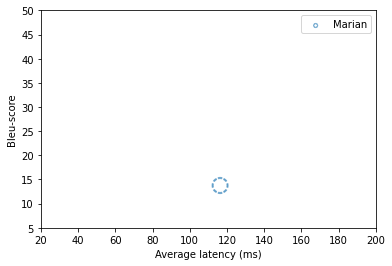

In [114]:
plot_metrics(perf_metrics, optim_type)

In [115]:
# koBart
model_ckpt2= 'circulus/kobart-trans-ko-en-v2' #bart`
pipe2 = pipeline('translation',model=model_ckpt2, max_length=256,device=0)
optim_type='koBart'
pb = PerformanceBenchmark(pipe2, ds["KoBart"], optim_type =optim_type)
perf_metrics.update(pb.run_benchmark())

모델 크기 (MB) - 472.69
평균 레이턴시 (ms) - 138.48 +\- 4.87
테스트 세트 블루 - 22.623


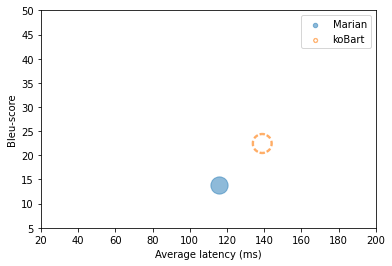

In [116]:
plot_metrics(perf_metrics, optim_type)

In [148]:
def compute_bleu(dataset,pipeline,model_name):
    """PerformanceBenchmark.compute_bleu() 메서드를 오버라이드합니다"""
    preds, labels, results = [], [],[]
    bleu_score = load_metric('sacrebleu')    
    for example in dataset:
        pred = pipeline(example["text"])[0]["translation_text"]
        label = example["intent"]
        bleu_score.add(prediction = pred, reference = [label])
        result = bleu_score.compute(smooth_method='floor',lowercase=True,use_effective_order=True)['score']
        labels.append(label)
        preds.append(pred)
        results.append(result)
    print('슝')
    return pd.DataFrame({'original':dataset['text'],'label':labels,f'pred_{model_name}' : preds, f'bleu_{model_name}': results})

In [149]:
model_result_tab = pd.DataFrame.from_dict(perf_metrics, orient='index')
model_result_tab

,size_mb,time_avg_ms,time_std_ms,score,counts,totals,precisions,bp,sys_len,ref_len
Marian,297.668641,115.505202,2.956114,13.878161,"[6577, 3178, 1731, 964]","[19046, 18046, 17046, 16048]","[34.53218523574504, 17.61055081458495, 10.1548...",1.000000,19046,13302
koBart,472.694695,138.479332,4.871025,22.622920,"[6649, 3500, 1932, 1067]","[11685, 10685, 9688, 8705]","[56.902011125374415, 32.75620028076743, 19.942...",0.870766,11685,13302


In [150]:
small = ds['Marian'].shard(num_shards=20,index=0)
eval_table = compute_bleu(small,pipe,'Marian')
eval_table.head()

/opt/conda/lib/python3.9/site-packages/transformers/pipelines/base.py:899: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


슝


,original,label,pred_Marian,bleu_Marian
0,먼저들 세상 떴어요.,The world came out first.,"First of all, we're out of the world.",5.612222
1,오늘 좀 춥죠. 안 그래요?,It's a little cold today. isn't it?,"It's cold today, isn't it?",16.168293
2,혹시 전화 오면 어디 계신지 꼭 알아놔.,"If you call, let me know where you are.","If you call, you'll find out where you are.",46.924701
3,지금 저한테 무슨말 하시는 거예요?,what are you saying to me now?,What are you talking about to me?,18.092176
4,이 놈의 식을 줄 모르는 인기는 어쩌면 좋냐?,Maybe this guy's undying popularity is good?,What about the popularity that you don't know ...,2.044801


In [151]:
# bottom 10
eval_table.sort_values(by='bleu_Marian').head(20)

,original,label,pred_Marian,bleu_Marian
13,그렇게 그렇게 안 말한다.,don't say that,That's not what I'm saying.,0.000000
12,죽진 않고,not dead,You don't die.,0.000000
44,약간 틀어 놓고 아~ 어디서 웃어야 되지 어~ 이게 재밌는 건가 조금 약간 싶어 가...,Turn it on a little bit Ah~ Where should I la...,I don't know if it's funny.,0.686226
15,가문잔치부터 하는 겁니다 잔치하려고 하면,Let's start with the family party. If you wan...,It's a family feast first.,1.198845
42,그러니까 뭔가 다리가 무릎이랑 엄청 아픈 거예요 원래 이 정도 일한다고 막 아프지가...,"So, something hurts my legs and knees a lot.","That's why my leg hurts so much with my knee, ...",1.429615
17,해외여행 일반화 된지 한 십년밖 십년 됐잖아#이 난 그전에 간거랑,It's only been 10 years since overseas travel...,I've been traveling abroad for about ten years...,1.739580
4,이 놈의 식을 줄 모르는 인기는 어쩌면 좋냐?,Maybe this guy's undying popularity is good?,What about the popularity that you don't know ...,2.044801
26,그런데 또 어느 적절하게 또 비 너무 비대하게 있으면,"But again, if it is appropriate and too bloated,",But if there's any other proper way to get too...,2.408856
31,끄트머리에 걸려서 이제 집을 부시던가 하 해야 되는 상황인데 그게 되니까 그 우리 ...,It got caught on the edge and now we have to ...,"You're stuck at the end of the stick, and now ...",2.547297
30,전세를 준다고 그러잖아.,They say they give you a charter.,He says he's paying rent.,2.925227


In [152]:
# top 10
eval_table.sort_values(by='bleu_Marian').tail(20)

,original,label,pred_Marian,bleu_Marian
45,저는 그~ 사극 같은 경우에는 저는 조금 뭐~ 역사 이런 것도 조금 좋아하고 하다 보니까,"When it comes to historical dramas, I like a ...","I'm a little bit of a fan of history, and so o...",17.694975
3,지금 저한테 무슨말 하시는 거예요?,what are you saying to me now?,What are you talking about to me?,18.092176
43,뭐~ 그럴 때는 뭐~ 옛날에는 조금,"Well~ At that time, what~ In the old days, a ...","Well, at the time, a little bit.",18.973559
33,그런데 딱 겉에서 봤을 때,"However, when viewed from the outside","But from the outside,",19.153996
34,날 이렇게 생각 안 하나 이런 생각한거 그러니까그게 근데 정이 많다는 게 그것도 성...,Don't you think of me like this?,"You don't think of me like this, but is it per...",24.078435
40,그런 조금 이제 감정적이거나 이런 것들 감정을 조금 공감을 잘하고,"I'm a little emotional now, or I'm good at emp...","Now I'm a little emotional, or I'm a little em...",25.336549
10,우리 언니 이 얘기 하는 것처럼 #이 그렇게 막 칭찬하고 하는데,"Like my sister is talking about, # is just gi...","Like my sister is saying this, she's just comp...",25.491834
36,흙냄새 나가지고 민물고기는 이렇게 잘 안 먹어주더라고,It smells like dirt and they don't eat freshw...,"It smells like dirt, so the freshwater fish do...",26.584836
48,그래서 아~ 조금 날 조금 따뜻해지면 가야지 이러는데 아직 못 나가고 있어요 그래서,So ah~ I'm going to go when it gets a little ...,"So I'm going to go when I get a little warm, a...",26.771264
16,한해 두해 막 그렇게 결정할 건 아닌데,I'm not going to make a decision just like th...,I'm not going to make that decision in less th...,31.177153


In [153]:
small = ds['KoBart'].shard(num_shards=20,index=0)
eval_table2 = compute_bleu(small,pipe2,'KoBart')
eval_table2.head()

/opt/conda/lib/python3.9/site-packages/transformers/pipelines/base.py:899: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


슝


,original,label,pred_KoBart,bleu_KoBart
0,먼저들 세상 떴어요.,The world came out first.,First of all the world is up,7.730552
1,오늘 좀 춥죠. 안 그래요?,It's a little cold today. isn't it?,Its a little cold today isnt it,32.668286
2,혹시 전화 오면 어디 계신지 꼭 알아놔.,"If you call, let me know where you are.",Please know where you are when you call me,29.538720
3,지금 저한테 무슨말 하시는 거예요?,what are you saying to me now?,What are you talking about to me,17.820132
4,이 놈의 식을 줄 모르는 인기는 어쩌면 좋냐?,Maybe this guy's undying popularity is good?,How is it good to be unable to cool down on him,2.025599


In [154]:
# bottom 20
eval_table2.sort_values(by='bleu_KoBart').head(20)

,original,label,pred_KoBart,bleu_KoBart
28,어 쉰다며?,How are you resting?,Yeshes saying youre going to rest,0.000000
43,뭐~ 그럴 때는 뭐~ 옛날에는 조금,"Well~ At that time, what~ In the old days, a ...",In th past times like that,0.916976
19,꼬셔보려고 하니까 할머니도 약아서 약은 생각으로 할아버지한테,"I tried to seduce him, but the grandmother wa...",I was going to try to try it so my grandmother...,1.365915
4,이 놈의 식을 줄 모르는 인기는 어쩌면 좋냐?,Maybe this guy's undying popularity is good?,How is it good to be unable to cool down on him,2.025599
41,주었니 하면서 아무거나 다 먹고,"Saying that you gave me something, I ate ever...",Did you give it to him and eat anything,2.145851
29,근데 저는 이제 너무 욱하다 보니까 이렇게 막 그~,"But now I'm so angry, so I just like that~",But Im so thick so Im like this,2.382541
10,우리 언니 이 얘기 하는 것처럼 #이 그렇게 막 칭찬하고 하는데,"Like my sister is talking about, # is just gi...",As you said you were complimenting like that,2.448626
14,했당 막 좋아 #게,"I did it, I really like it",Its really good to do it let me load it,2.777619
49,그러다 보니까 또 사이도 뭔가 어색해지고 그랬어가지고 그게 조금 힘들었고,"Then again, things got awkward between us and...",As a result the relationship became awkward an...,3.350203
30,전세를 준다고 그러잖아.,They say they give you a charter.,You said you would give me a lease,3.655552


In [155]:
# top 10
eval_table2.sort_values(by='bleu_KoBart').tail(20)

,original,label,pred_KoBart,bleu_KoBart
3,지금 저한테 무슨말 하시는 거예요?,what are you saying to me now?,What are you talking about to me,17.820132
33,그런데 딱 겉에서 봤을 때,"However, when viewed from the outside",But from the outside,18.782965
17,해외여행 일반화 된지 한 십년밖 십년 됐잖아#이 난 그전에 간거랑,It's only been 10 years since overseas travel...,Its been only a decade since overseas travel b...,19.038379
47,다 기본적으로 하는 거 그 정도만 할 수 있고,Basically everything you can do,You can do all the basics,20.205155
9,넌 좀 덜봤으면 좋겠다 제발 좀.,I hope you see less please.,I hope you look less please,21.506254
39,그런 플랫폼이 조금 많았어요.,There were a few platforms like that.,There were a lot of platforms like that,23.119742
38,할 말들이 조금 많잖아요 그래서 얘기를 조금 많이 나눴었는데,"You have a lot to say, so we talked a little bit",There were a lot of things to say so we talked...,26.130227
18,저 하나 더 벗 붙여 봐라 저 아이 딸이라도 꼭 아들 아니더라도 볼 수 있어야 된다.,Attach one more friend to me. Even if that ch...,Take it off and put it on another one Even if ...,28.582660
2,혹시 전화 오면 어디 계신지 꼭 알아놔.,"If you call, let me know where you are.",Please know where you are when you call me,29.538720
21,서울에서 아르바이트 찾기가 힘든 거야 언니.,"It's hard to find a part-time job in Seoul, s...",Its hard to find a parttime job in Seoul,30.930508


In [158]:
comparison_table = eval_table.merge(eval_table2, on='original')

In [166]:
col_use = ['original','label_x','pred_Marian','pred_KoBart', 'bleu_Marian','bleu_KoBart']

In [169]:
comparison_table=comparison_table[col_use].copy()

In [170]:
comparison_table['diff'] = comparison_table["bleu_Marian"] - comparison_table["bleu_KoBart"]

<AxesSubplot:>

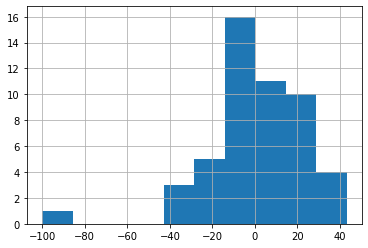

In [171]:
comparison_table['diff'].hist()

In [172]:
comparison_table.sort_values(by='diff')

,original,label_x,pred_Marian,pred_KoBart,bleu_Marian,bleu_KoBart,diff
12,죽진 않고,not dead,You don't die.,Not dead,0.000000,100.000000,-100.000000
37,x 반대로 자기가 조금 비벼 볼 만한 사람한테는 되게 세게 나가고,"x On the contrary, he goes out very hard to s...","On the other hand, if you're a little bit down...",On the contrary he goes out very hard to someo...,3.502541,43.949005,-40.446464
5,무슨 그런 말씀을,what do you say,I don't know what you're saying.,What do you mean,3.303164,39.763536,-36.460372
15,가문잔치부터 하는 겁니다 잔치하려고 하면,Let's start with the family party. If you wan...,It's a family feast first.,If you want to have a family party first,1.198845,33.918022,-32.719177
6,내가 어떻게 쓰는지 봐요 알겠죠?,"See how I write, okay?","Let's see how I'm using it, okay?",Letk see how I write it OK,14.923729,41.113362,-26.189632
18,저 하나 더 벗 붙여 봐라 저 아이 딸이라도 꼭 아들 아니더라도 볼 수 있어야 된다.,Attach one more friend to me. Even if that ch...,You need to be able to see her daughter even i...,Take it off and put it on another one Even if ...,10.594543,28.582660,-17.988117
17,해외여행 일반화 된지 한 십년밖 십년 됐잖아#이 난 그전에 간거랑,It's only been 10 years since overseas travel...,I've been traveling abroad for about ten years...,Its been only a decade since overseas travel b...,1.739580,19.038379,-17.298799
1,오늘 좀 춥죠. 안 그래요?,It's a little cold today. isn't it?,"It's cold today, isn't it?",Its a little cold today isnt it,16.168293,32.668286,-16.499994
9,넌 좀 덜봤으면 좋겠다 제발 좀.,I hope you see less please.,I want you to see less. Come on.,I hope you look less please,5.612222,21.506254,-15.894032
47,다 기본적으로 하는 거 그 정도만 할 수 있고,Basically everything you can do,That's all I can do.,You can do all the basics,8.633400,20.205155,-11.571755
